In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
from scipy.misc import imresize
from scipy import ndimage

%matplotlib inline

import tensorflow as tf
from keras.layers import Dense, Activation, Flatten, Lambda, BatchNormalization, Reshape, Dropout
from keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from keras.engine import merge, Input, Model
from keras.optimizers import SGD
from keras.callbacks import Callback, LearningRateScheduler, ModelCheckpoint, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
import keras.backend as K
import time
import random
import pickle
import json
import csv
from tqdm import tqdm
from natsort import natsorted

from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report

from helper import to_rle
from segmentation import *
from stochastic_depth_resnet import *

DATADIR = os.path.expanduser('~/data/kaggle/ultrasound-nerve-segmentation')
PROCDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/processed')
MODELDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/models')
SUBMITDIR = os.path.expanduser('~/ml/kaggle/ultrasound-nerve-segmentation/submissions')

Using TensorFlow backend.


In [3]:
WEIGHTS_PRESENCE_FILEPATH = os.path.join(MODELDIR, 'model-05-presence-weights.hdf5')
HISTORY_PRESENCE_FILEPATH = os.path.join(MODELDIR, 'model-05-presence-training-history.json')

WEIGHTS_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-05-segment-weights.hdf5')
HISTORY_SEGMENT_FILEPATH = os.path.join(MODELDIR, 'model-05-segment-training-history.json')

In [4]:
with open(os.path.join(PROCDIR, 'train_files_map.pkl'), 'rb') as f:
    train_files_map = pickle.load(f)
with open(os.path.join(PROCDIR, 'test_files_map.pkl'), 'rb') as f:
    test_files_map = pickle.load(f)

In [5]:
with open(os.path.join(PROCDIR, 'data_train_val_05.pkl'), 'rb') as f:
    (data_images_all_train, data_images_all_val, 
     data_presence_train, data_presence_val, 
     data_images_pos_train, data_images_pos_val, 
     data_masks_pos_train, data_masks_pos_val) = pickle.load(f)

print('image (all) shapes:', data_images_all_train.shape, data_images_all_val.shape)
print('presence label shapes:', data_presence_train.shape, data_presence_val.shape)
print('image (pos) shapes:', data_images_pos_train.shape, data_images_pos_val.shape)
print('mask (pos) shapes:', data_masks_pos_train.shape, data_masks_pos_val.shape)

image (all) shapes: (20624, 128, 192, 1) (479, 128, 192, 1)
presence label shapes: (20624,) (479,)
image (pos) shapes: (8544, 128, 192, 1) (187, 128, 192, 1)
mask (pos) shapes: (8544, 128, 192) (187, 128, 192)


## presence model

In [6]:
start_time = time.time()

orig_img_rows, orig_img_cols = 420, 580
img_rows, img_cols = 128, 192
img_channels = 1

blocks_per_group = 10
nb_total_blocks = 5 * blocks_per_group

with tf.device('/gpu:0'):
    
    images_presence = Input(shape=(img_rows, img_cols, img_channels))

    x = Convolution2D(4, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_presence)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 4
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)
        
with tf.device('/gpu:1'):

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    x = AveragePooling2D(pool_size=(8, 8), strides=None, border_mode='valid', dim_ordering='tf')(x)
    x = Flatten()(x)
    presence = Dense(1, activation='sigmoid')(x)

    model_presence = Model(input=images_presence, output=presence)

print('model init time: {}'.format(time.time() - start_time))

start_time = time.time()

model_presence.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

print('model compile time: {}'.format(time.time() - start_time))

model init time: 27.229867458343506
model compile time: 5.97313117980957


## presence model train

In [ ]:
batch_size = 64
nb_epoch = 1

# Model saving callback
#checkpointer = ModelCheckpoint(filepath=WEIGHTS_PRESENCE_FILEPATH, verbose=1, save_best_only=True)

# Early stopping
#early_stopping = EarlyStopping(monitor='val_loss', patience=10)

history = model_presence.fit(data_images_all_train, data_presence_train,
                             batch_size=batch_size, nb_epoch=nb_epoch, verbose=1,
                             validation_data=(data_images_all_val, data_presence_val), shuffle=True,
                             callbacks=[])

#with open(HISTORY_PRESENCE_FILEPATH, 'w') as f_out:
#    json.dump(history.history, f_out)

## segmentation model

In [7]:
start_time = time.time()

orig_img_rows, orig_img_cols = 420, 580
img_rows, img_cols = 128, 192
img_channels = 1

blocks_per_group = 4
nb_total_blocks = 5 * blocks_per_group

with tf.device('/gpu:0'):
    
    images_segment = Input(shape=(img_rows, img_cols, img_channels))

    x = Convolution2D(8, 3, 3, subsample=(1, 1),
                      init='he_normal', border_mode='same', dim_ordering='tf')(images_segment)
    x = BatchNormalization(axis=3)(x)
    x = Activation('relu')(x)

    for i in range(0, blocks_per_group):
        nb_filters = 8
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=1)

    for i in range(0, blocks_per_group):
        nb_filters = 16
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f2 = x
    f2 = UpSampling2D(size=(2, 2), dim_ordering='tf')(f2)
    f2 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f2)

    for i in range(0, blocks_per_group):
        nb_filters = 32
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=2 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f4 = x
    f4 = UpSampling2D(size=(4, 4), dim_ordering='tf')(f4)
    f4 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f4)
        
with tf.device('/gpu:1'):

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=3 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f8 = x
    f8 = UpSampling2D(size=(8, 8), dim_ordering='tf')(f8)
    f8 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f8)

    for i in range(0, blocks_per_group):
        nb_filters = 64
        if i == 0:
            subsample_factor = 2
        else:
            subsample_factor = 1
        x = stochastic_depth_residual_block(x, nb_filters=nb_filters,
                                            block=4 * blocks_per_group + i, nb_total_blocks=nb_total_blocks,
                                            subsample_factor=subsample_factor)

    f16 = x
    f16 = UpSampling2D(size=(16, 16), dim_ordering='tf')(f16)
    f16 = Convolution2D(8, 3, 3, init='he_uniform', border_mode='same', activation='relu', dim_ordering='tf')(f16)

    segmentation = merge([f16, f8, f4, f2], mode='concat', concat_axis=-1)   
    segmentation = Convolution2D(1, 1, 1, 
                                 activation='sigmoid', 
                                 init='uniform', border_mode='same', dim_ordering='tf')(segmentation)
    segmentation = Reshape((img_rows, img_cols))(segmentation)

    model_segment = Model(input=images_segment, output=segmentation)

print('model init time: {}'.format(time.time() - start_time))

start_time = time.time()

model_segment.compile(optimizer='adam', loss=binaryCE, metrics=[dice_coeff])

print('model compile time: {}'.format(time.time() - start_time))

model init time: 38.034818172454834
model compile time: 3.54858660697937


## test

In [11]:
with open(os.path.join(PROCDIR, 'data_train_val_01.pkl'), 'rb') as f:
    data_images_train, data_masks_train, data_images_val, data_masks_val = pickle.load(f)
    
print('image shapes:', data_images_train.shape, data_images_val.shape)
print('mask shapes:', data_masks_train.shape, data_masks_val.shape)

image shapes: (5155, 128, 192, 1) (480, 128, 192, 1)
mask shapes: (5155, 128, 192) (480, 128, 192)


In [9]:
model_presence.load_weights(os.path.join(MODELDIR, 'model-05-presence-weights.hdf5'))

In [10]:
model_segment.load_weights(os.path.join(MODELDIR, 'model-01-weights.hdf5'))

presence prediction:  [ 0.32125226] [False]


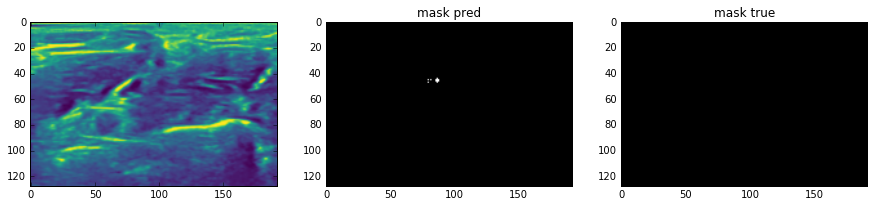

In [25]:
rand_i = random.randint(0, data_images_val.shape[0] - 1)

presence = model_presence.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0]
print('presence prediction: ', presence, presence > 0.5)

plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plt.imshow(data_images_val[rand_i, :, :, 0], cmap=plt.cm.viridis)
plt.subplot(1,3,2)
plt.title('mask pred')
plt.imshow(model_segment.predict(data_images_val[rand_i:rand_i+1], verbose=0)[0, :, :] > 0.5, cmap=plt.cm.bone)
plt.subplot(1,3,3)
plt.title('mask true')
plt.imshow(data_masks_val[rand_i, :, :], cmap=plt.cm.bone)

In [29]:
preds_segment = model_segment.predict(data_images_val, verbose=0)
np.mean(2 * np.sum(data_masks_val * preds_segment>0.5) / (np.sum(data_masks_val) + np.sum(preds_segment>0.5) + 1e-6), axis=None)

0.62895139489265706

In [31]:
preds_mod = []
for i in range(preds_segment.shape[0]):
    preds_mod.append(ndimage.morphology.binary_fill_holes(preds_segment[i,:,:]>0.5))
preds_mod = np.array(preds_mod, dtype=np.bool)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.6291806083228928

In [75]:
preds_presence = model_presence.predict(data_images_val, verbose=0)
preds_segment = model_segment.predict(data_images_val, verbose=0)
preds_mod = []
for i in range(preds_segment.shape[0]):
    if preds_presence[i] < 0.3:
        preds_mod.append(preds_segment[i,:,:]>0.9)
    elif preds_presence[i] > 0.75:
        preds_mod.append(preds_segment[i,:,:]>0.35)
    else:
        preds_mod.append(preds_segment[i,:,:]>0.5)
np.mean(2 * np.sum(data_masks_val * preds_mod) / (np.sum(data_masks_val) + np.sum(preds_mod) + 1e-6), axis=None)

0.65131025842326284

In [77]:
with open(os.path.join(SUBMITDIR, 'model-05.csv'), 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['img', 'pixels'])

    for key in tqdm(natsorted(list(test_files_map.keys()))):
        file_info = test_files_map[key]
        img, folder, img_file = file_info['img'], file_info['folder'], file_info['img_file']
        img_filepath = os.path.join(folder, img_file)
        image = io.imread(img_filepath) / 255.0
        image_resized = np.expand_dims(imresize(image, size=(img_rows, img_cols), interp='bilinear'), axis=3)
        presence = model_presence.predict(np.array([image_resized], dtype=np.float32), verbose=0)[0]
        mask_pred = model_segment.predict(np.array([image_resized], dtype=np.float32), verbose=0)
        if presence < 0.3:
            mask_pred = mask_pred[0, :, :] > 0.9
        elif presence > 0.75:
            mask_pred = mask_pred[0, :, :] > 0.35
        else:
            mask_pred = mask_pred[0, :, :] > 0.5
        mask_pred_orig_size = imresize(mask_pred, size=(orig_img_rows, orig_img_cols), interp='bilinear').astype(np.bool)
        rle = to_rle(mask_pred_orig_size)
        writer.writerow([img, rle])

 11%|█         | 596/5508 [01:04<09:47,  8.36it/s]/home/leon/install/miniconda3/lib/python3.5/site-packages/skimage/external/tifffile/tifffile.py:1794: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
100%|██████████| 5508/5508 [10:18<00:00,  9.27it/s]
